In [1]:
import pandas as pd

data = pd.read_csv("citrus.csv")
print(data.shape)
data.head()

(10000, 6)


,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2
3,orange,4.47,95.60,163,81,4
4,orange,4.48,95.76,161,72,9


In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

enc = LabelEncoder()
data["name"] = enc.fit_transform(data["name"])
data.head()

,name,diameter,weight,red,green,blue
0,1,2.96,86.76,172,85,2
1,1,3.91,88.05,166,78,3
2,1,4.42,95.17,156,81,2
3,1,4.47,95.60,163,81,4
4,1,4.48,95.76,161,72,9


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("name", axis=1),
    data["name"],
    test_size=0.33,
    random_state=42
)

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train.shape, X_test.shape, X_train_scaled.shape, X_test_scaled.shape

((6700, 5), (3300, 5), (6700, 5), (3300, 5))

In [7]:
from sklearn.metrics import (
    accuracy_score, # доля правильных ответов
    precision_score, # точность
    recall_score, # полнота
    confusion_matrix, # TN, TP, FN, FP -- для подсчёта TNR, точности и полноты для бинарной классификации
    multilabel_confusion_matrix, # возвращает список confusion_matrix (для многоклассового случая -- будет использоваться далее)
    f1_score, # F1-мера
    roc_auc_score, # ROC AUC
    roc_curve, # возвращает FPR, TPR и пороговые значения, которые использовались при подсчёте FPR и TPR
    average_precision_score, # PR AUC
    precision_recall_curve # возвращает точность, полноту и пороговые значения, которые использовались при подсчёте точности и полноты
)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [9]:
def calculate_precision_recall_f1(tn, fp, fn, tp):
    """Подсчёт точности, полноты и F1-меры по формулам.

    :param tn: true negative
    :param fp: false positive
    :param fn: false negative
    :param tp: true positive
    :return: точность, полнота, F1-мера
    """
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 / (precision + recall) * precision * recall

    return precision, recall, f1

In [10]:
import numpy as np

def calculate_specificity(true_labels, predictions):
    """Вычисление специфичности для бинарной и многоклассовой классификации.

    :param true_labels: истинные метки классов
    :param predictions: предсказанные метки классов
    :return: специфичность и confusion_matrix
    """
    if len(np.unique(true_labels)) < 3:
        conf_matrix = confusion_matrix(true_labels, predictions)
        tn, fp, fn, tp = conf_matrix.ravel()
        return tn / (tn + fp), (tn, fp, fn, tp)
    else:
        # в многоклассовом случае будем использовать только макро-аггрегацию
        conf_matrix = multilabel_confusion_matrix(true_labels, predictions)
        specificity = []

        for cm in conf_matrix:
            tn, fp, fn, tp = cm.ravel()
            specificity.append(tn / (tn + fp))
        return np.array(specificity).mean(), conf_matrix

In [11]:
def get_all_metrics(
    true_labels,
    predictions,
    probabilities,
    print_metrics=False,
    **kwargs,
):
    """Подсчёт и вывод всех метрик.

    :param true_labels: истинные метки классов
    :param predictions: предсказания (метки классов)
    :param probabilities: предсказания (вероятности принадлежности каждого объекта к каждому классу)
    :param print_metrics: если True, то печатает получившиеся метрики
    :return: словарь, ключи которого -- названия метрик, значения -- получившиеся метрики
    """
    kwargs_precision_recall_f1_pr_auc = dict() # для бинарной классификации никакие дополнительные параметры не нужны
    kwargs_roc_auc = dict()

    # если бинарная классификация, то используем только вероятности принадлежности к классу 1
    if len(np.unique(true_labels)) < 3:
        probabilities = probabilities[:, 1]
        true_predicted_labels_precision_recall_f1 = {
            "y_true": true_labels,
            "y_pred": predictions,
        }
        true_predicted_labels_pr_auc = {
            "y_true": true_labels,
            "y_score": probabilities,
        }
    # если многоклассовая классификация, то устанавливаем дополнительные параметры для посчета метрик
    else:
        kwargs_precision_recall_f1_pr_auc = {
            "average": kwargs["average"],
        }
        kwargs_roc_auc = {
            "multi_class": kwargs["multi_class"]
        }
        true_labels_binarize = label_binarize(true_labels, classes=np.unique(true_labels))
        predictions_binarize = label_binarize(predictions, classes=np.unique(predictions))
        true_predicted_labels_precision_recall_f1 = {
            "y_true": true_labels_binarize,
            "y_pred": predictions_binarize,
        }
        true_predicted_labels_pr_auc = {
            "y_true": true_labels_binarize,
            "y_score": probabilities,
        }
    accuracy = accuracy_score(true_labels, predictions)

    precision = precision_score(**true_predicted_labels_precision_recall_f1, **kwargs_precision_recall_f1_pr_auc)
    recall = recall_score(**true_predicted_labels_precision_recall_f1, **kwargs_precision_recall_f1_pr_auc)
    f1 = f1_score(**true_predicted_labels_precision_recall_f1, **kwargs_precision_recall_f1_pr_auc)

    roc_auc = roc_auc_score(true_labels, probabilities, **kwargs_roc_auc)
    pr_auc = average_precision_score(**true_predicted_labels_pr_auc, **kwargs_precision_recall_f1_pr_auc)

    specificity, conf_matrix = calculate_specificity(true_labels, predictions)

    if len(np.unique(true_labels)) < 3:
        # Для бинарной классификации сравним точность, полноту и F1-меру, полученные с помощью sklearn
        # с вычисленными по формулам данными метриками (просто дополнительно выведем их)
        tn, fp, fn, tp = conf_matrix
        precision_cm, recall_cm, f1_cm = calculate_precision_recall_f1(tn, fp, fn, tp)

        if print_metrics:
            print(
                "Accuracy = {}\nPrecision (from sklearn) = {}; Precision (from scratch) = {}\nRecall (from sklearn) = {}; Recall (from scratch) = {}\nF1_score (from sklearn) = {}; F1_score (from scratch) = {}\nROC AUC = {}\nPR AUC = {}\nSpecificity = {}".format(
                    accuracy, precision, precision_cm, recall, recall_cm, f1, f1_cm, roc_auc, pr_auc, specificity
                )
            )

    else:
        if print_metrics:
            print(
                "Accuracy = {}\nPrecision = {}\nRecall = {}\nF1_score = {}\nROC AUC = {}\nPR AUC = {}\nSpecificity = {}".format(
                    accuracy, precision, recall, f1, roc_auc, pr_auc, specificity
                )
            )
    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_score": f1,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc,
        "Specificity": specificity
    }

Функция для вычесления метрик

In [12]:
from sklearn.preprocessing import label_binarize

def model_train_test(X_train, y_train, X_test, y_test, model, **kwargs):
    """Обучение и тестирование модели на обучающей и тестовой выборке соответственно.

    :param X_train: объекты обучающей выборки
    :param y_train: значения целевой переменной обучающей выборки
    :param X_test: объекты тестовой выборки
    :param y_test: значения целевой переменной тестовой выборки
    :param model: модель, которая обучается и тестируется
    :return: предсказания -- классы и вероятности принадлежности к каждому классу, все метрики
    """
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    proba = model.predict_proba(X_test)

    print(str(model), end="\n\n")

    all_metrics = get_all_metrics(
        y_test,
        pred,
        proba,
        print_metrics=True,
        **kwargs,
    )
    return pred, proba, all_metrics

Функиция для обучения и тестирования модели


# Сравнение алгоритмов

Логическая регрессия

In [16]:
pred_logreg, proba_logreg, all_metrics_logreg = model_train_test(
    X_train_scaled, y_train.values,
    X_test_scaled, y_test.values,
    LogisticRegression()
)

LogisticRegression()

Accuracy = 0.9406060606060606
Precision (from sklearn) = 0.9458483754512635; Precision (from scratch) = 0.9458483754512635
Recall (from sklearn) = 0.9368295589988082; Recall (from scratch) = 0.9368295589988082
F1_score (from sklearn) = 0.9413173652694612; F1_score (from scratch) = 0.9413173652694611
ROC AUC = 0.9852883254535006
PR AUC = 0.9870894578577022
Specificity = 0.9445129469790382


Решающее дерево

In [17]:
pred_dt, proba_dt, all_metrics_dt = model_train_test(
    X_train, y_train.values,
    X_test, y_test.values,
    DecisionTreeClassifier()
)

DecisionTreeClassifier()

Accuracy = 0.9348484848484848
Precision (from sklearn) = 0.9409282700421941; Precision (from scratch) = 0.9409282700421941
Recall (from sklearn) = 0.9302741358760429; Recall (from scratch) = 0.9302741358760429
F1_score (from sklearn) = 0.9355708720407552; F1_score (from scratch) = 0.9355708720407554
ROC AUC = 0.9349274501821645
PR AUC = 0.9107757787893875
Specificity = 0.9395807644882861


Метод k-ближайших соседей 

In [18]:
pred_knn, proba_knn, all_metrics_knn = model_train_test(
    X_train_scaled, y_train.values,
    X_test_scaled, y_test.values,
    KNeighborsClassifier()
)

KNeighborsClassifier()

Accuracy = 0.9190909090909091
Precision (from sklearn) = 0.9211940298507463; Precision (from scratch) = 0.9211940298507463
Recall (from sklearn) = 0.9195470798569726; Recall (from scratch) = 0.9195470798569726
F1_score (from sklearn) = 0.920369818073367; F1_score (from scratch) = 0.9203698180733672
ROC AUC = 0.9610868657861438
PR AUC = 0.9504129952839617
Specificity = 0.9186189889025894


Метод опорных векторов

In [19]:
pred_svm, proba_svm, all_metrics_svm = model_train_test(
    X_train_scaled, y_train.values,
    X_test_scaled, y_test.values,
    SVC(probability=True)
)

SVC(probability=True)

Accuracy = 0.933030303030303
Precision (from sklearn) = 0.9391199517781796; Precision (from scratch) = 0.9391199517781796
Recall (from sklearn) = 0.9284862932061978; Recall (from scratch) = 0.9284862932061978
F1_score (from sklearn) = 0.9337728498651482; F1_score (from scratch) = 0.9337728498651483
ROC AUC = 0.9755780911748325
PR AUC = 0.9795827478157114
Specificity = 0.937731196054254


In [20]:
import matplotlib.pyplot as plt

def plot_roc_pr_curves(true_labels, algorithms):
    """Отрисовка ROC- и PR-кривых.

    :param true_labels: истинные метки классов
    :param algorithms: словарь формата {название_алгоритма: вероятности_принадлежности_к_каждому_классу}
    """
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    ax[0].set_title("ROC-curve", fontsize=20)
    ax[1].set_title("PR-curve", fontsize=20)

    for alg_name, probabilities in algorithms.items():
        fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
        precisions, recalls, _ = precision_recall_curve(true_labels, probabilities[:, 1])

        ax[0].plot(
            fpr,
            tpr,
            label="{} (ROC AUC = {})".format(
                alg_name,
                round(
                    roc_auc_score(true_labels, probabilities[:, 1]),
                    3
                )
            )
        )
        ax[1].plot(
            recalls,
            precisions,
            label="{} (PR AUC = {})".format(
                alg_name,
                round(
                    average_precision_score(true_labels, probabilities[:, 1]),
                    3
                )
            )
        )

    ax[0].legend(fontsize=14)
    ax[0].set_xlabel("False positive rate", fontsize=16)
    ax[0].set_ylabel("True positive rate", fontsize=16)

    ax[1].legend(fontsize=14)
    ax[1].set_xlabel("Recall", fontsize=16)
    ax[1].set_ylabel("Precision", fontsize=16)
    plt.show()

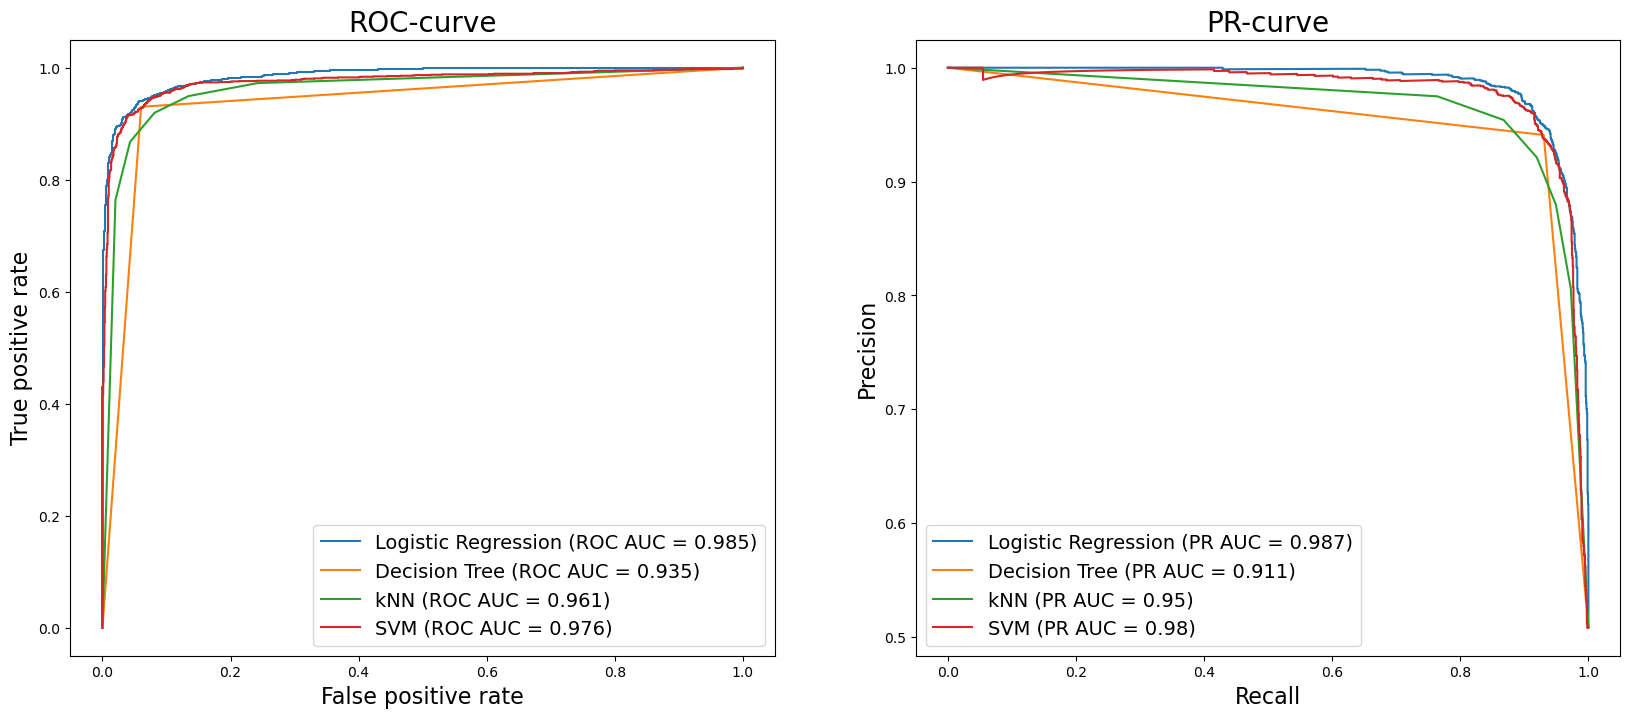

In [21]:
plot_roc_pr_curves(
    y_test,
    {
        "Logistic Regression": proba_logreg,
        "Decision Tree": proba_dt,
        "kNN": proba_knn,
        "SVM": proba_svm,
    }
)

По данным с графика мы можем сделать вывод, что логическая регрессия является лучшей среди всех, но остальные ей не уступают.

###### Сгенерируем все метрики

In [22]:
ans_df = pd.DataFrame(
    [all_metrics_logreg, all_metrics_dt, all_metrics_knn, all_metrics_svm],
    index=["Logistic Regression", "Decision Tree", "kNN", "SVM"]
)
ans_df

,Accuracy,Precision,Recall,F1_score,ROC AUC,PR AUC,Specificity
Logistic Regression,0.940606,0.945848,0.936830,0.941317,0.985288,0.987089,0.944513
Decision Tree,0.934848,0.940928,0.930274,0.935571,0.934927,0.910776,0.939581
kNN,0.919091,0.921194,0.919547,0.920370,0.961087,0.950413,0.918619
SVM,0.933030,0.939120,0.928486,0.933773,0.975578,0.979583,0.937731


Создадим список по убыванию качества моделей.

In [23]:
for metric in ans_df.columns:
    sorted_ans_df = ans_df.sort_values(by=metric, ascending=False)
    print(
        "{}:{}{}".format(
            metric,
            " " * (20 - len(metric)),
            sorted_ans_df.index.tolist()
        )
    )

Accuracy:            ['Logistic Regression', 'Decision Tree', 'SVM', 'kNN']
Precision:           ['Logistic Regression', 'Decision Tree', 'SVM', 'kNN']
Recall:              ['Logistic Regression', 'Decision Tree', 'SVM', 'kNN']
F1_score:            ['Logistic Regression', 'Decision Tree', 'SVM', 'kNN']
ROC AUC:             ['Logistic Regression', 'SVM', 'kNN', 'Decision Tree']
PR AUC:              ['Logistic Regression', 'SVM', 'kNN', 'Decision Tree']
Specificity:         ['Logistic Regression', 'Decision Tree', 'SVM', 'kNN']


Как и по резулитатам графика мы делаем вывод, что логическая регрессия лучше остальных.

# Многоклассовя классификация

In [25]:
from sklearn.datasets import load_wine

wine_data = load_wine()
wine_data.keys()

df = pd.DataFrame(wine_data["data"], columns=wine_data["feature_names"])
target = wine_data["target"]

df.head()

pd.Series(target).value_counts()

1    71
0    59
2    48
Name: count, dtype: int64

Делим выборку на обучающую и тестовую

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.33, random_state=42)

### Обучение и тестирование моделей

Функция обучает и тестирует модель, а также проводит подсчет метрик для различных вариантов агрегации метрик.

In [27]:
def all_average_multi_class_combinations(X_train, y_train, X_test, y_test, model, verbose=0):
    """После обучения и тестирования модели используются всевозможные аггрегации метрик.

    :param X_train: обучающая выборка
    :param y_train: целевая переменная обучающей выборки
    :param X_test: тестовая выборка
    :param y_test: целевая переменная тестовой выборки
    :param model: классификатор
    :param verbose: если 0, то выводятся только точность, полнота, F1-мера, ROC AUC и PR AUC для различных вариантов аггрегаций, иначе -- все метрики для каждого варианта аггрегации
    :return: точность, полнота, F1-мера, ROC AUC и PR AUC для различных вариантов аггрегаций
    """
    # average="macro" и multi_class="ovr" -> ROC AUC чувствителен к несбалансированности классов
    # average="macro" и multi_class="ovo" -> ROC AUC не чувствителен к несбалансированности классов

    model.fit(X_train, y_train) # обучение модели
    pred = model.predict(X_test) # получение предсказаний (классов)
    proba = model.predict_proba(X_test) # получение предсказаний (вероятности принадлежности к каждому классу)

    if verbose > 0:
        print(str(model), end="\n\n")

    ans = dict()
    ans["ROC AUC"] = dict()
    metrics_to_compare = ["Precision", "Recall", "F1_score", "PR AUC"]
    for m in metrics_to_compare:
        ans[m] = dict()

    for average in ["macro", "micro", "weighted"]:
        for multi_class in ["ovr", "ovo"]:
            if verbose > 0:
                print("\n{}_{}".format(average, multi_class))

            # вычисление всех метрик
            all_metrics = get_all_metrics(
                y_test,
                pred,
                proba,
                calc_specificity=False,
                print_metrics=verbose > 0,
                average=average,
                multi_class=multi_class,
            )

            for m in metrics_to_compare:
                ans[m][average] = all_metrics[m]
            ans["ROC AUC"][multi_class] = all_metrics["ROC AUC"]
    if verbose > 0:
        print("-"*100, end="\n\n")
    for k, v in ans.items():
        print(k, "\n", v)
    return ans

### Cравнивать решающее дерево c  случайным лесом.

In [28]:
dt = all_average_multi_class_combinations(
    X_train, y_train,
    X_test, y_test,
    DecisionTreeClassifier(),
    verbose=1,
)

DecisionTreeClassifier()


macro_ovr
Accuracy = 0.9491525423728814
Precision = 0.9629629629629629
Recall = 0.9444444444444443
F1_score = 0.9513540443400591
ROC AUC = 0.957936507936508
PR AUC = 0.9243565599497803
Specificity = 0.9714285714285714

macro_ovo
Accuracy = 0.9491525423728814
Precision = 0.9629629629629629
Recall = 0.9444444444444443
F1_score = 0.9513540443400591
ROC AUC = 0.9583333333333334
PR AUC = 0.9243565599497803
Specificity = 0.9714285714285714

micro_ovr
Accuracy = 0.9491525423728814
Precision = 0.9491525423728814
Recall = 0.9491525423728814
F1_score = 0.9491525423728814
ROC AUC = 0.957936507936508
PR AUC = 0.9178397012352772
Specificity = 0.9714285714285714

micro_ovo
Accuracy = 0.9491525423728814
Precision = 0.9491525423728814
Recall = 0.9491525423728814
F1_score = 0.9491525423728814
ROC AUC = 0.9583333333333334
PR AUC = 0.9178397012352772
Specificity = 0.9714285714285714

weighted_ovr
Accuracy = 0.9491525423728814
Precision = 0.9548022598870056
Recall = 0.9491525423

In [29]:
from sklearn.ensemble import RandomForestClassifier

rf = all_average_multi_class_combinations(
    X_train, y_train,
    X_test, y_test,
    RandomForestClassifier(),
    verbose=1,
)

RandomForestClassifier()


macro_ovr
Accuracy = 1.0
Precision = 1.0
Recall = 1.0
F1_score = 1.0
ROC AUC = 1.0
PR AUC = 1.0
Specificity = 1.0

macro_ovo
Accuracy = 1.0
Precision = 1.0
Recall = 1.0
F1_score = 1.0
ROC AUC = 1.0
PR AUC = 1.0
Specificity = 1.0

micro_ovr
Accuracy = 1.0
Precision = 1.0
Recall = 1.0
F1_score = 1.0
ROC AUC = 1.0
PR AUC = 1.0
Specificity = 1.0

micro_ovo
Accuracy = 1.0
Precision = 1.0
Recall = 1.0
F1_score = 1.0
ROC AUC = 1.0
PR AUC = 1.0
Specificity = 1.0

weighted_ovr
Accuracy = 1.0
Precision = 1.0
Recall = 1.0
F1_score = 1.0
ROC AUC = 1.0
PR AUC = 1.0
Specificity = 1.0

weighted_ovo
Accuracy = 1.0
Precision = 1.0
Recall = 1.0
F1_score = 1.0
ROC AUC = 1.0
PR AUC = 1.0
Specificity = 1.0
----------------------------------------------------------------------------------------------------

ROC AUC 
 {'ovr': 1.0, 'ovo': 1.0}
Precision 
 {'macro': 1.0, 'micro': 1.0, 'weighted': 1.0}
Recall 
 {'macro': 1.0, 'micro': 1.0, 'weighted': 1.0}
F1_score 
 {'macro': 1.0, 'm

In [31]:
from sklearn.tree import plot_tree

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)


RandomForestClassifier()

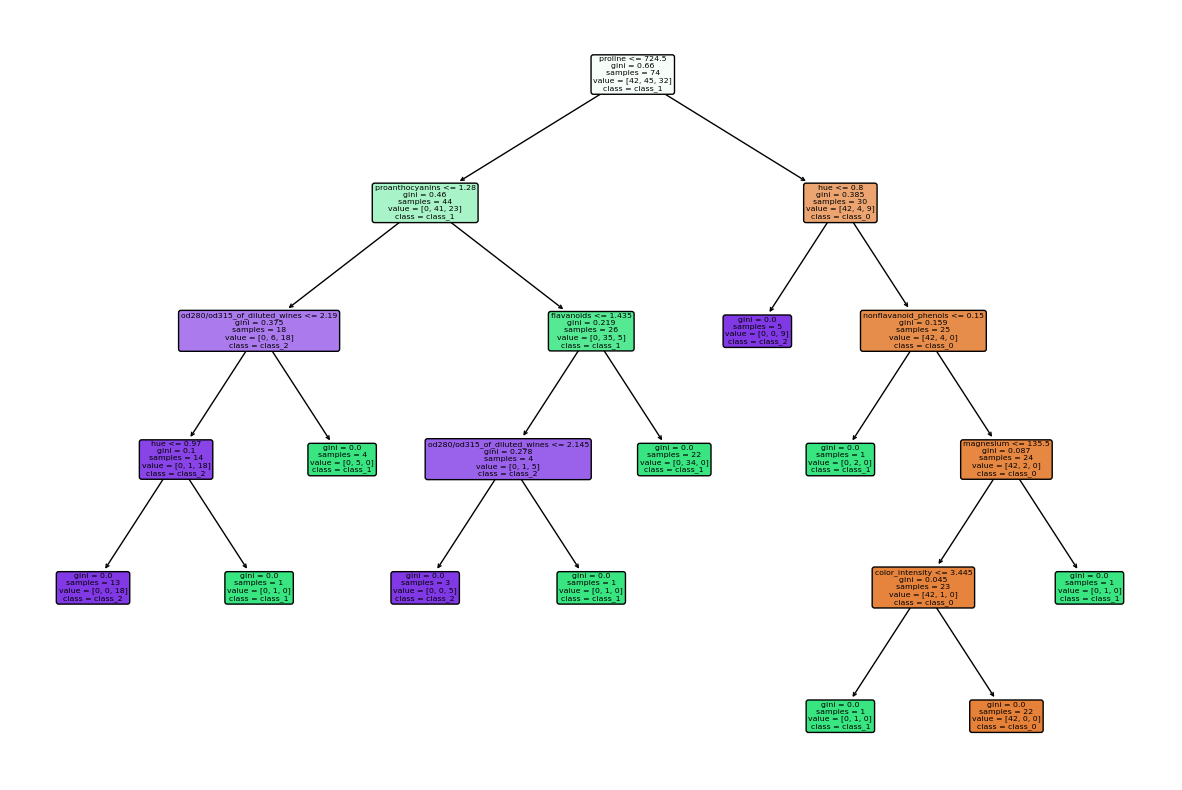

In [37]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

individual_tree = rf_clf.estimators_[0]

class_names_list = wine_data.target_names.tolist()

fig = plt.figure(figsize=(15, 10))
plot_tree(
    individual_tree,
    feature_names=wine_data.feature_names,
    class_names=class_names_list, 
    filled=True,
    impurity=True,
    rounded=True
)
plt.show()